### Libraries

In [1]:
import os
import glob
import nibabel as nb
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
from brainspace.datasets import load_mask

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# libraries
import numpy as np
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.mesh.mesh_creation import build_polydata
import copy
from brainstat.datasets import fetch_mask
import matplotlib.cm as cm
import scipy as sp
from matplotlib.colors import ListedColormap
import cmocean

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np; np.random.seed(2)
import random; random.seed(2)
import joypy

### Variables

In [2]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Path to MICAPIPE surf = mask_5k !
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

inf32_lh = read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
inf32_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')

mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

# Load spheres fsLR5k
sphere_lh = read_surface(micapipe+'/surfaces/fsLR-5k.L.sphere.surf.gii', itype='gii')
sphere_rh = read_surface(micapipe+'/surfaces/fsLR-5k.R.sphere.surf.gii', itype='gii')

# load stuff
mask_32k = load_mask(join=True)
mask_surf32 = mask_32k != 0

# Labels and boolean mask
mask_surf = mask_5k != 0

# Inflated fsLR-5k surfaces
f5k_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.surf.gii', itype='gii')
f5k_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.surf.gii', itype='gii')

# Load fsaverage5
fs5_lh = read_surface(micapipe+'/surfaces/fsaverage5/surf/lh.pial', itype='fs')
fs5_rh = read_surface(micapipe+'/surfaces/fsaverage5/surf/rh.pial', itype='fs')
fs5_mask = fetch_mask("fsaverage5")

## Mesulam classes (Downsample to fsLR5k)

/tmp/ipykernel_2255056/920649602.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm.get_cmap('viridis', 5)


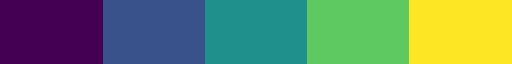

In [201]:
cm.get_cmap('viridis', 5)

In [202]:
mesuL_5k =  nb.load(micapipe + '/surfaces/fsLR-5k.L_mesulam.shape.gii').darrays[0].data
mesuR_5k =  nb.load(micapipe + '/surfaces/fsLR-5k.R_mesulam.shape.gii').darrays[0].data
mesu_5k = np.concatenate((mesuL_5k, mesuR_5k), axis=0)
mesu_5k_round = np.round(mesu_5k)

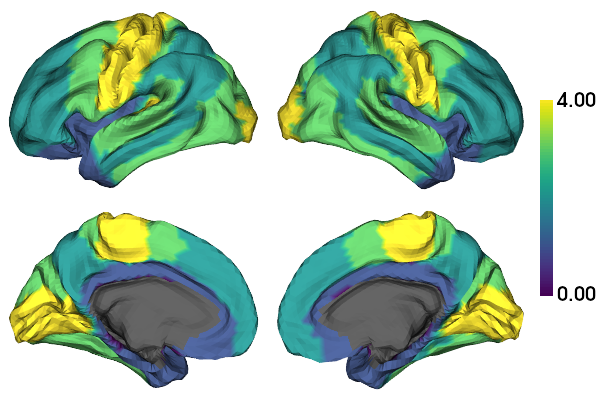

In [203]:
mesu_5k_round[mask_5k == False] = np.nan

# plot labels on surface
plot_hemispheres(f5k_lh, f5k_rh, mesu_5k_round, cmap='viridis', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.6, size=(600, 400), embed_nb=True, layout_style='grid',
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

In [240]:
uni_mesu5k = np.unique(mesu_5k_round[mask_5k==True])
index = {val: np.where(mesu_5k_round == val)[0] for val in uni_mesu5k}

In [158]:
# Copy the index dictionary to prevent modification of the original
new_index = orig_index.copy()
# Combine the indices of keys 0 and 1
new_index[0] = np.concatenate((orig_index[1], orig_index[0]))
new_index[0] = np.sort(new_index[0])

# Delete the key for 1
del new_index[1]
# Update the index dictionary
index = new_index

# Copy the index dictionary to prevent modification of the original
new_index = {}
# Reassign the indices with updated keys
for idx, key in enumerate(index.keys()):
    new_index[idx] = index[key]

In [258]:
SWM_mMPC = np.load('/host/percy/local_raid/youngeun/myjupyter/array/mMPC_5k_SWM_G1.npy')
SWM_T1map = np.load('/host/percy/local_raid/youngeun/myjupyter/array/T1map_SWM_G1.npy')
SWM_MTSAT_old = np.load('/host/percy/local_raid/youngeun/myjupyter/array/MTSAT_SWM_G1.npy')
SWM_MTSAT_new = np.load('/host/percy/local_raid/youngeun/myjupyter/array/MTSAT_SWM_G1_new.npy')
SWM_FA = np.load('/host/percy/local_raid/youngeun/myjupyter/array/FA_SWM_G1.npy')
SWM_ODI = np.load('/host/percy/local_raid/youngeun/myjupyter/array/ODI_SWM_G1.npy')

GM_T1map = np.load('/host/percy/local_raid/youngeun/myjupyter/array/T1map_GM_G1.npy')

/tmp/ipykernel_2255056/1601639050.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Unique Value', y='SWM_mMPC', data=df, palette=custom_palette, linewidth=2)


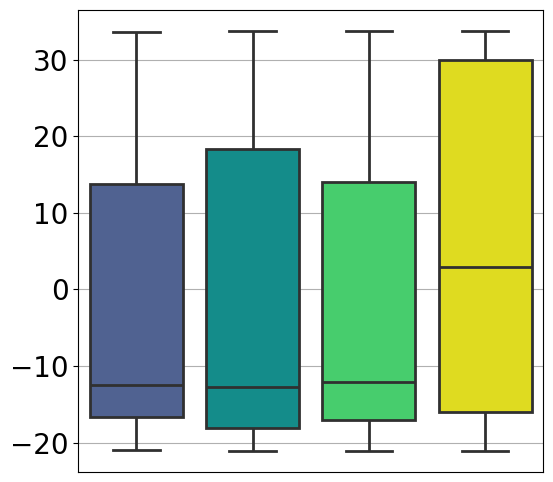

In [241]:
# Prepare data for seaborn
data_for_plot = []
for val in [1,2,3,4]:
    non_nan_values = SWM_mMPC[index[val]][~np.isnan(SWM_mMPC[index[val]])]
    data_for_plot.extend([(val, v) for v in non_nan_values])

# Convert to DataFrame
df = pd.DataFrame(data_for_plot, columns=['Unique Value', 'SWM_mMPC'])

# Define custom colors for each boxplot
custom_palette = ['#455d9cff', '#00a09dff', '#31e363ff', '#fffa00ff']

# Plot the boxplot using seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(x='Unique Value', y='SWM_mMPC', data=df, palette=custom_palette, linewidth=2)
plt.xlabel('')
plt.ylabel('')
#plt.title('Boxplot of SWM_mMPC Values for Each Unique Value in Array')
plt.grid(True)

# Change x-axis labels
#new_labels = ['PARALIMBIC', 'HETEROMODAL', 'UNIMODAL', 'IDIOTYPIC']
plt.xticks(ticks=[])
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed

plt.show()

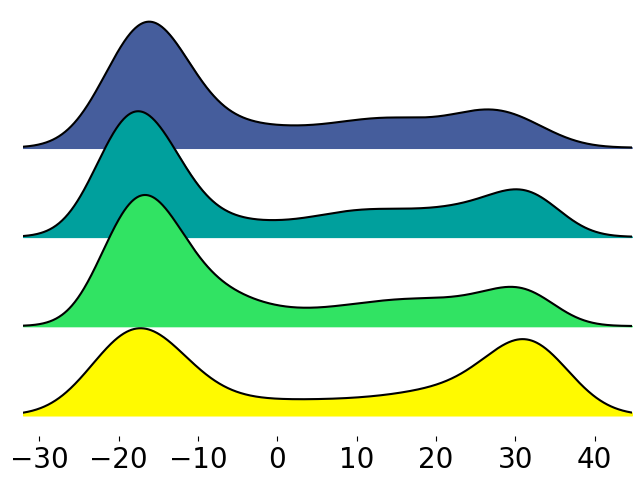

In [242]:
grouped_data = [df[df['Unique Value'] == val]['SWM_mMPC'].values for val in df['Unique Value'].unique()]

fig, ax = joypy.joyplot(grouped_data, color = custom_palette)

plt.xticks(fontsize=20)
plt.show()

In [243]:
unique_values = df['Unique Value'].unique()

# Iterate through each unique value to create and evaluate a regression model
for value in unique_values:
    # Filter the dataframe for the current unique value
    df_filtered = df[df['Unique Value'] == value]
    
    # Set features and target
    y = df_filtered['SWM_mMPC']
    
    # Add a constant term for the intercept
    X = sm.add_constant(df_filtered[['Unique Value']])
    
    # Initialize and train the regression model using statsmodels
    model = sm.OLS(y, X).fit()
    
    # Make predictions
    y_pred = model.predict(X)
    
    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Extract p-value for the independent variable
    p_value = model.pvalues['Unique Value']
    
    # Extract the regression coefficients
    coef = model.params['Unique Value']
    
    print(f'Unique Value: {value}')
    print(f'MSE: {mse}')
    print(f'R2: {r2}')
    print(f'p-value: {p_value}')
    print(f'Coefficients (Predictors): {coef}')

    #print(model.summary())
    print('-' * 50)

Unique Value: 1
MSE: 310.27562112640146
R2: 2.220446049250313e-16
p-value: 1.0465458954690506e-06
Coefficients (Predictors): -2.583092673921969
--------------------------------------------------
Unique Value: 2
MSE: 389.28569381597964
R2: 0.0
p-value: 0.00573300602688682
Coefficients (Predictors): -0.4923124839252247
--------------------------------------------------
Unique Value: 3
MSE: 331.80601254664134
R2: 1.1102230246251565e-16
p-value: 2.724772173655087e-14
Coefficients (Predictors): -0.887919252686162
--------------------------------------------------
Unique Value: 4
MSE: 478.35587255937037
R2: 0.0
p-value: 2.831315584644421e-25
Coefficients (Predictors): 1.353410069670821
--------------------------------------------------


/tmp/ipykernel_2255056/640158916.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Unique Value', y='SWM_T1map', data=df, palette=custom_palette, linewidth=2)


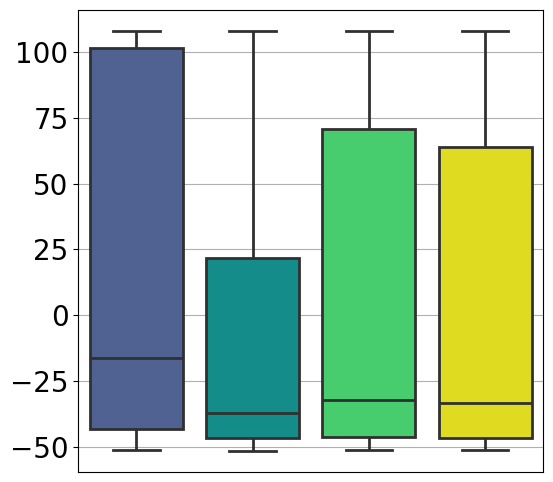

In [244]:
# Prepare data for seaborn
data_for_plot = []
for val in [1,2,3,4]:
    non_nan_values = SWM_T1map[index[val]][~np.isnan(SWM_T1map[index[val]])]
    data_for_plot.extend([(val, v) for v in non_nan_values])

# Convert to DataFrame
df = pd.DataFrame(data_for_plot, columns=['Unique Value', 'SWM_T1map'])

# Define custom colors for each boxplot
custom_palette = ['#455d9cff', '#00a09dff', '#31e363ff', '#fffa00ff']

# Plot the boxplot using seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(x='Unique Value', y='SWM_T1map', data=df, palette=custom_palette, linewidth=2)
plt.xlabel('')
plt.ylabel('')
#plt.title('Boxplot of SWM_T1map Values for Each Unique Value in Array')
plt.grid(True)

# Change x-axis labels
#new_labels = ['PARALIMBIC', 'HETEROMODAL', 'UNIMODAL', 'IDIOTYPIC']
plt.xticks(ticks=[])
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed

plt.show()

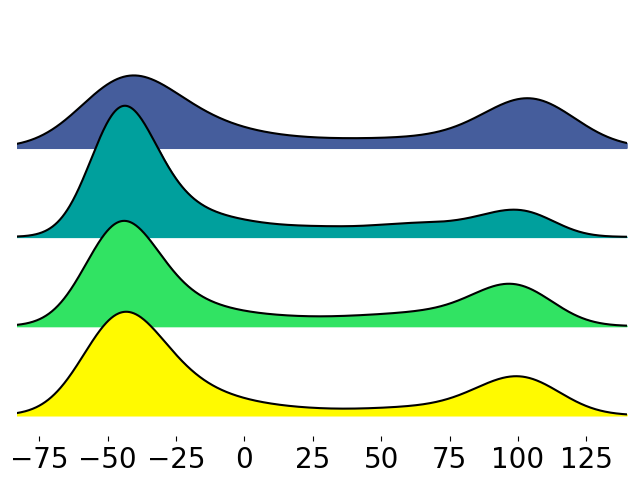

In [245]:
grouped_data = [df[df['Unique Value'] == val]['SWM_T1map'].values for val in df['Unique Value'].unique()]

fig, ax = joypy.joyplot(grouped_data, color = custom_palette)

plt.xticks(fontsize=20)
plt.show()

In [246]:
unique_values = df['Unique Value'].unique()

# Iterate through each unique value to create and evaluate a regression model
for value in unique_values:
    # Filter the dataframe for the current unique value
    df_filtered = df[df['Unique Value'] == value]
    
    # Set features and target
    y = df_filtered['SWM_T1map']
    
    # Add a constant term for the intercept
    X = sm.add_constant(df_filtered[['Unique Value']])
    
    # Initialize and train the regression model using statsmodels
    model = sm.OLS(y, X).fit()
    
    # Make predictions
    y_pred = model.predict(X)
    
    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Extract p-value for the independent variable
    p_value = model.pvalues['Unique Value']

    # Extract the regression coefficients
    coef = model.params['Unique Value']
    
    print(f'Unique Value: {value}')
    print(f'MSE: {mse}')
    print(f'R2: {r2}')
    print(f'p-value: {p_value}')
    print(f'Coefficients (Predictors): {coef}')

    #print(model.summary())
    print('-' * 50)

Unique Value: 1
MSE: 4212.656293004748
R2: -4.440892098500626e-16
p-value: 1.0599721649995686e-18
Coefficients (Predictors): 17.42045616304961
--------------------------------------------------
Unique Value: 2
MSE: 2820.4407990289483
R2: 0.0
p-value: 6.402395481898774e-16
Coefficients (Predictors): -3.89463961207473
--------------------------------------------------
Unique Value: 3
MSE: 3599.8269406473355
R2: 0.0
p-value: 0.0011748217990038793
Coefficients (Predictors): 1.241551362689945
--------------------------------------------------
Unique Value: 4
MSE: 3577.0555194318754
R2: 0.0
p-value: 0.9730891989824271
Coefficients (Predictors): 0.011841135485757378
--------------------------------------------------


/tmp/ipykernel_2255056/2583927232.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Unique Value', y='GM_T1map', data=df, palette=custom_palette, linewidth=2)


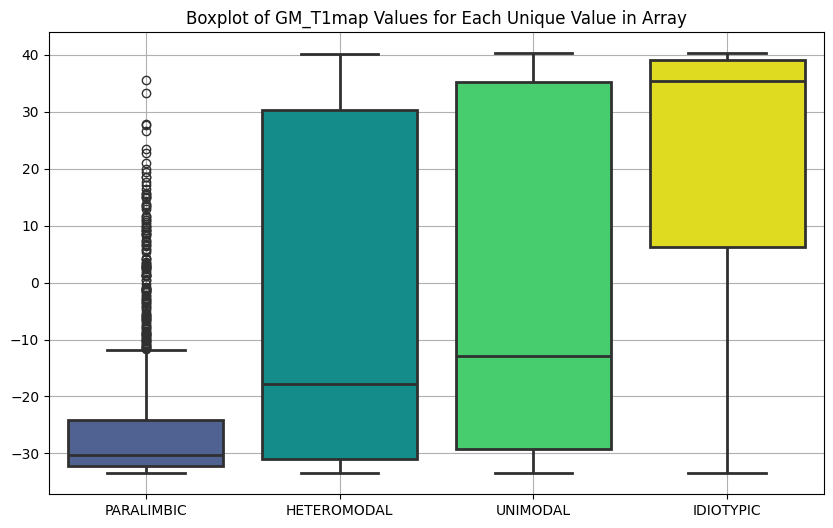

In [247]:
# Prepare data for seaborn
data_for_plot = []
for val in [1,2,3,4]:
    non_nan_values = GM_T1map[index[val]][~np.isnan(GM_T1map[index[val]])]
    data_for_plot.extend([(val, v) for v in non_nan_values])

# Convert to DataFrame
df = pd.DataFrame(data_for_plot, columns=['Unique Value', 'GM_T1map'])

# Define custom colors for each boxplot
custom_palette = ['#455d9cff', '#00a09dff', '#31e363ff', '#fffa00ff']

# Plot the boxplot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Unique Value', y='GM_T1map', data=df, palette=custom_palette, linewidth=2)
plt.xlabel('')
plt.ylabel('')
plt.title('Boxplot of GM_T1map Values for Each Unique Value in Array')
plt.grid(True)

# Change x-axis labels
new_labels = ['PARALIMBIC', 'HETEROMODAL', 'UNIMODAL', 'IDIOTYPIC']
plt.xticks(ticks=[0, 1, 2, 3], labels=new_labels)

plt.show()

In [248]:
unique_values = df['Unique Value'].unique()

# Iterate through each unique value to create and evaluate a regression model
for value in unique_values:
    # Filter the dataframe for the current unique value
    df_filtered = df[df['Unique Value'] == value]
    
    # Set features and target
    y = df_filtered['GM_T1map']
    
    # Add a constant term for the intercept
    X = sm.add_constant(df_filtered[['Unique Value']])
    
    # Initialize and train the regression model using statsmodels
    model = sm.OLS(y, X).fit()
    
    # Make predictions
    y_pred = model.predict(X)
    
    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Extract p-value for the independent variable
    p_value = model.pvalues['Unique Value']
    
    # Extract the regression coefficients
    coef = model.params['Unique Value']
    
    print(f'Unique Value: {value}')
    print(f'MSE: {mse}')
    print(f'R2: {r2}')
    print(f'p-value: {p_value}')
    print(f'Coefficients (Predictors): {coef}')

    #print(model.summary())
    print('-' * 50)

Unique Value: 1
MSE: 144.11687504518517
R2: 0.0
p-value: 0.0
Coefficients (Predictors): -25.088848302058818
--------------------------------------------------
Unique Value: 2
MSE: 817.7926407889521
R2: 0.0
p-value: 9.404145724893498e-16
Coefficients (Predictors): -2.084825567703522
--------------------------------------------------
Unique Value: 3
MSE: 878.9862895314469
R2: 0.0
p-value: 0.718859169717199
Coefficients (Predictors): -0.0679956221128097
--------------------------------------------------
Unique Value: 4
MSE: 553.0299064366839
R2: 0.0
p-value: 4.1501235443715473e-258
Coefficients (Predictors): 5.619949653737251
--------------------------------------------------


/tmp/ipykernel_2255056/1260935303.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Unique Value', y='SWM_MTSAT_new', data=df, palette=custom_palette, linewidth=2)


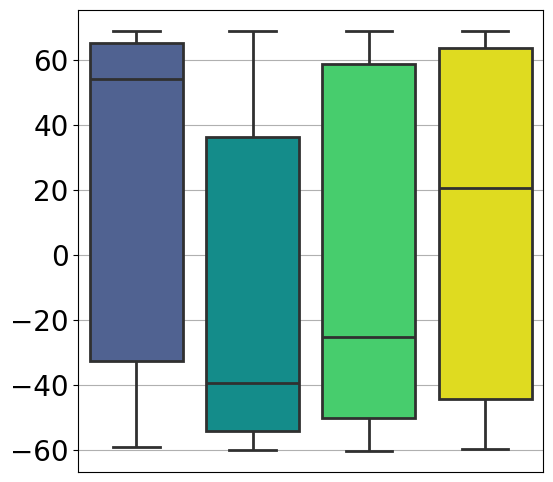

In [249]:
# Prepare data for seaborn
data_for_plot = []
for val in [1,2,3,4]:
    non_nan_values = SWM_MTSAT_new[index[val]][~np.isnan(SWM_MTSAT_new[index[val]])]
    data_for_plot.extend([(val, v) for v in non_nan_values])

# Convert to DataFrame
df = pd.DataFrame(data_for_plot, columns=['Unique Value', 'SWM_MTSAT_new'])

# Define custom colors for each boxplot
custom_palette = ['#455d9cff', '#00a09dff', '#31e363ff', '#fffa00ff']

# Plot the boxplot using seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(x='Unique Value', y='SWM_MTSAT_new', data=df, palette=custom_palette, linewidth=2)
plt.xlabel('')
plt.ylabel('')
#plt.title('Boxplot of SWM_MTSAT Values for Each Unique Value in Array')
plt.grid(True)

# Change x-axis labels
#new_labels = ['PARALIMBIC', 'HETEROMODAL', 'UNIMODAL', 'IDIOTYPIC']
plt.xticks(ticks=[])
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed

plt.show()

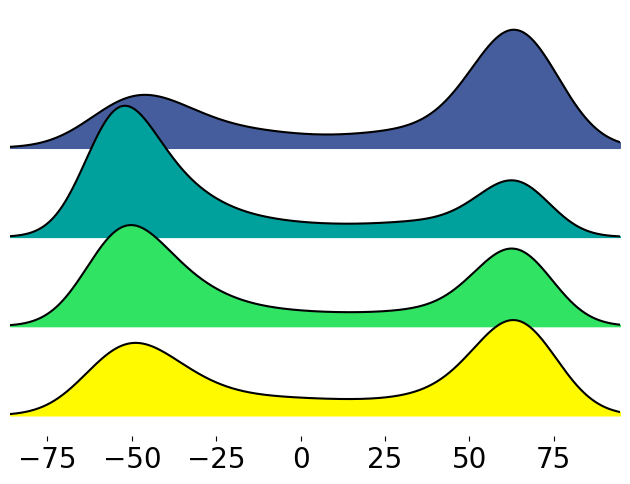

In [250]:
grouped_data = [df[df['Unique Value'] == val]['SWM_MTSAT_new'].values for val in df['Unique Value'].unique()]

fig, ax = joypy.joyplot(grouped_data, color = custom_palette)

plt.xticks(fontsize=20)
plt.show()

In [251]:
unique_values = df['Unique Value'].unique()

# Iterate through each unique value to create and evaluate a regression model
for value in unique_values:
    # Filter the dataframe for the current unique value
    df_filtered = df[df['Unique Value'] == value]
    
    # Set features and target
    y = df_filtered['SWM_MTSAT_new']
    
    # Add a constant term for the intercept
    X = sm.add_constant(df_filtered[['Unique Value']])
    
    # Initialize and train the regression model using statsmodels
    model = sm.OLS(y, X).fit()
    
    # Make predictions
    y_pred = model.predict(X)
    
    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Extract p-value for the independent variable
    p_value = model.pvalues['Unique Value']
    
    # Extract the regression coefficients
    coef = model.params['Unique Value']
    
    print(f'Unique Value: {value}')
    print(f'MSE: {mse}')
    print(f'R2: {r2}')
    print(f'p-value: {p_value}')
    print(f'Coefficients (Predictors): {coef}')

    #print(model.summary())
    print('-' * 50)

Unique Value: 1
MSE: 2350.15937622284
R2: 0.0
p-value: 1.5643248987354762e-53
Coefficients (Predictors): 23.541731125834332
--------------------------------------------------
Unique Value: 2
MSE: 2254.1645304500757
R2: 0.0
p-value: 1.5732956123112328e-60
Coefficients (Predictors): -7.190469542356215
--------------------------------------------------
Unique Value: 3
MSE: 2554.6467526038355
R2: 0.0
p-value: 0.02904737972246185
Coefficients (Predictors): -0.7031995619901442
--------------------------------------------------
Unique Value: 4
MSE: 2576.675149725278
R2: 0.0
p-value: 2.574681163081244e-19
Coefficients (Predictors): 2.7069759569897283
--------------------------------------------------


/tmp/ipykernel_2255056/2757363495.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Unique Value', y='SWM_FA', data=df, palette=custom_palette, linewidth=2)


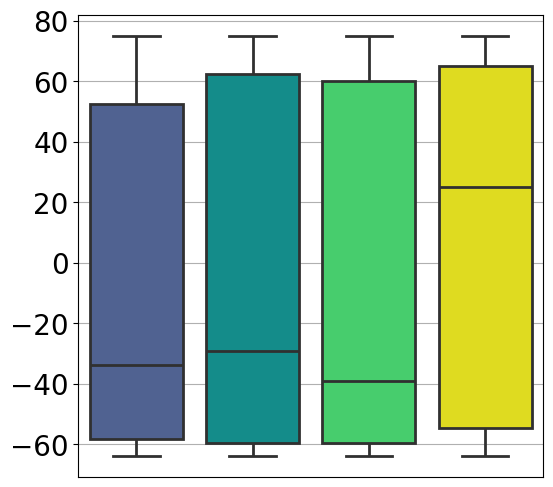

In [252]:
# Prepare data for seaborn
data_for_plot = []
for val in [1,2,3,4]:
    non_nan_values = SWM_FA[index[val]][~np.isnan(SWM_FA[index[val]])]
    data_for_plot.extend([(val, v) for v in non_nan_values])

# Convert to DataFrame
df = pd.DataFrame(data_for_plot, columns=['Unique Value', 'SWM_FA'])

# Define custom colors for each boxplot
custom_palette = ['#455d9cff', '#00a09dff', '#31e363ff', '#fffa00ff']

# Plot the boxplot using seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(x='Unique Value', y='SWM_FA', data=df, palette=custom_palette, linewidth=2)
plt.xlabel('')
plt.ylabel('')
#plt.title('Boxplot of SWM_FA Values for Each Unique Value in Array')
plt.grid(True)

# Change x-axis labels
#new_labels = ['PARALIMBIC', 'HETEROMODAL', 'UNIMODAL', 'IDIOTYPIC']
plt.xticks(ticks=[])
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed

plt.show()

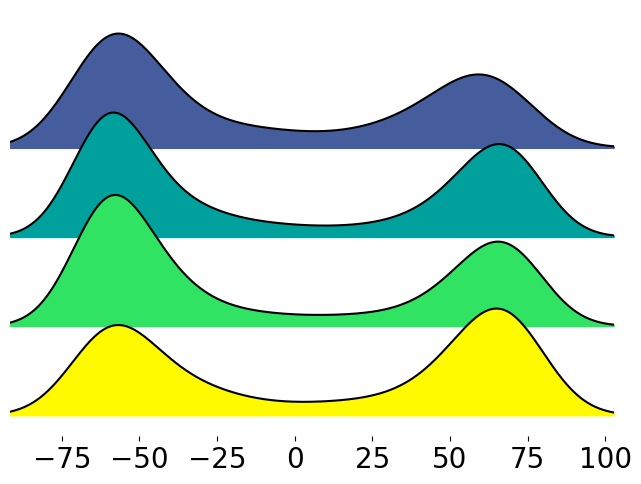

In [253]:
grouped_data = [df[df['Unique Value'] == val]['SWM_FA'].values for val in df['Unique Value'].unique()]

fig, ax = joypy.joyplot(grouped_data, color = custom_palette)

plt.xticks(fontsize=20)
plt.show()

In [254]:
unique_values = df['Unique Value'].unique()

# Iterate through each unique value to create and evaluate a regression model
for value in unique_values:
    # Filter the dataframe for the current unique value
    df_filtered = df[df['Unique Value'] == value]
    
    # Set features and target
    y = df_filtered['SWM_FA']
    
    # Add a constant term for the intercept
    X = sm.add_constant(df_filtered[['Unique Value']])
    
    # Initialize and train the regression model using statsmodels
    model = sm.OLS(y, X).fit()
    
    # Make predictions
    y_pred = model.predict(X)
    
    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Extract p-value for the independent variable
    p_value = model.pvalues['Unique Value']
    
    # Extract the regression coefficients
    coef = model.params['Unique Value']
    
    print(f'Unique Value: {value}')
    print(f'MSE: {mse}')
    print(f'R2: {r2}')
    print(f'p-value: {p_value}')
    print(f'Coefficients (Predictors): {coef}')

    #print(model.summary())
    print('-' * 50)

Unique Value: 1
MSE: 2803.7849957859876
R2: 0.0
p-value: 1.9231739813416016e-06
Coefficients (Predictors): -7.569989689509727
--------------------------------------------------
Unique Value: 2
MSE: 3242.5379695104184
R2: 0.0
p-value: 0.0036770946041627902
Coefficients (Predictors): -1.4939500380401074
--------------------------------------------------
Unique Value: 3
MSE: 3161.461556700642
R2: 0.0
p-value: 1.1748474878206827e-10
Coefficients (Predictors): -2.316602308633289
--------------------------------------------------
Unique Value: 4
MSE: 3142.9737193078154
R2: 0.0
p-value: 1.1731667599946958e-10
Coefficients (Predictors): 2.1320261980740662
--------------------------------------------------


/tmp/ipykernel_2255056/3381375228.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Unique Value', y='SWM_ODI', data=df, palette=custom_palette, linewidth=2)


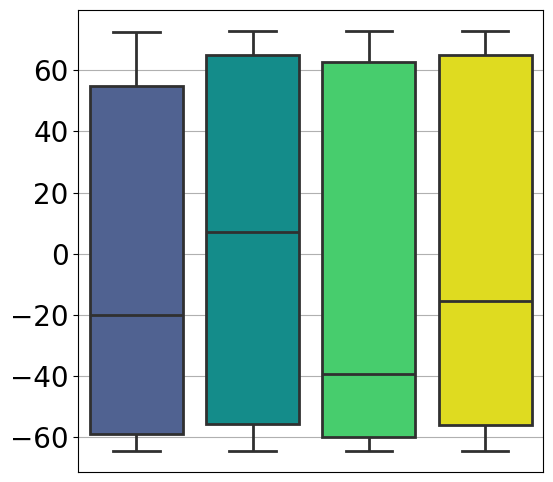

In [259]:
# Prepare data for seaborn
data_for_plot = []
for val in [1,2,3,4]:
    non_nan_values = SWM_ODI[index[val]][~np.isnan(SWM_ODI[index[val]])]
    data_for_plot.extend([(val, v) for v in non_nan_values])

# Convert to DataFrame
df = pd.DataFrame(data_for_plot, columns=['Unique Value', 'SWM_ODI'])

# Define custom colors for each boxplot
custom_palette = ['#455d9cff', '#00a09dff', '#31e363ff', '#fffa00ff']

# Plot the boxplot using seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(x='Unique Value', y='SWM_ODI', data=df, palette=custom_palette, linewidth=2)
plt.xlabel('')
plt.ylabel('')
#plt.title('Boxplot of SWM_ODI Values for Each Unique Value in Array')
plt.grid(True)

# Change x-axis labels
#new_labels = ['PARALIMBIC', 'HETEROMODAL', 'UNIMODAL', 'IDIOTYPIC']
plt.xticks(ticks=[])
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed

plt.show()

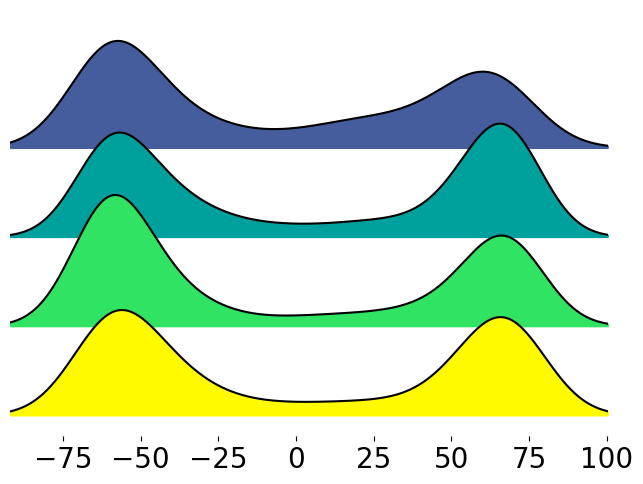

In [260]:
grouped_data = [df[df['Unique Value'] == val]['SWM_ODI'].values for val in df['Unique Value'].unique()]

fig, ax = joypy.joyplot(grouped_data, color = custom_palette)

plt.xticks(fontsize=20)
plt.show()

In [257]:
unique_values = df['Unique Value'].unique()

# Iterate through each unique value to create and evaluate a regression model
for value in unique_values:
    # Filter the dataframe for the current unique value
    df_filtered = df[df['Unique Value'] == value]
    
    # Set features and target
    y = df_filtered['SWM_ODI']
    
    # Add a constant term for the intercept
    X = sm.add_constant(df_filtered[['Unique Value']])
    
    # Initialize and train the regression model using statsmodels
    model = sm.OLS(y, X).fit()
    
    # Make predictions
    y_pred = model.predict(X)
    
    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Extract p-value for the independent variable
    p_value = model.pvalues['Unique Value']
    
    # Extract the regression coefficients
    coef = model.params['Unique Value']
    
    print(f'Unique Value: {value}')
    print(f'MSE: {mse}')
    print(f'R2: {r2}')
    print(f'p-value: {p_value}')
    print(f'Coefficients (Predictors): {coef}')

    #print(model.summary())
    print('-' * 50)

Unique Value: 1
MSE: 3519.1288817598306
R2: 0.0
p-value: 5.4515626804486e-08
Coefficients (Predictors): 9.69736384624263
--------------------------------------------------
Unique Value: 2
MSE: 3975.338071803455
R2: 0.0
p-value: 0.2740812159929859
Coefficients (Predictors): -0.6225000052586936
--------------------------------------------------
Unique Value: 3
MSE: 4071.6344877165347
R2: 0.0
p-value: 1.5665588097610373e-19
Coefficients (Predictors): 3.7025779858852386
--------------------------------------------------
Unique Value: 4
MSE: 4028.4608220246528
R2: 0.0
p-value: 0.07096827541000213
Coefficients (Predictors): 0.6729256577425147
--------------------------------------------------


## Von Economo classes (Downsample to fsLR5k)

/tmp/ipykernel_2255056/829215853.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm.get_cmap('gist_earth', 8)


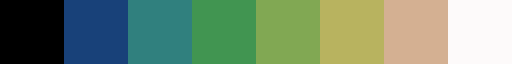

In [185]:
cm.get_cmap('gist_earth', 8)

In [186]:
ecoL_5k =  nb.load('/data/mica1/03_projects/youngeun/parc/economo_fsLR5k.L.shape.gii').darrays[0].data
ecoR_5k =  nb.load('/data/mica1/03_projects/youngeun/parc/economo_fsLR5k.R.shape.gii').darrays[0].data
eco_5k = np.concatenate((ecoL_5k, ecoR_5k), axis=0)
eco_5k_round = np.round(eco_5k)

/tmp/ipykernel_2255056/276768006.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', 7)


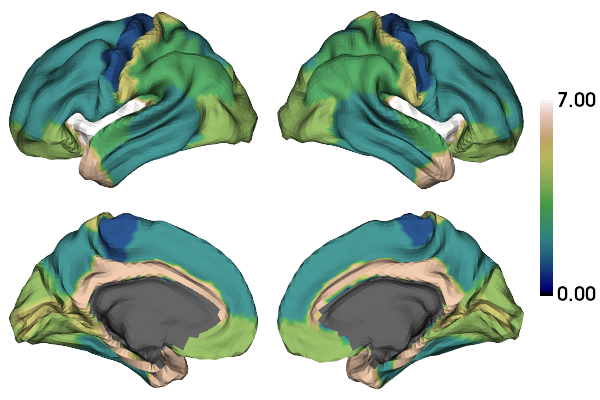

In [187]:
eco_5k_round[mask_5k == False] = np.nan
#Accent
cmap = cm.get_cmap('viridis', 7)
# plot labels on surface
plot_hemispheres(f5k_lh, f5k_rh, eco_5k_round, cmap='gist_earth', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.6, size=(600, 400), embed_nb=True, layout_style='grid',
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

In [262]:
uni_eco5k = np.unique(eco_5k_round[mask_5k==True])
index = {val: np.where(eco_5k_round == val)[0] for val in uni_eco5k}

In [101]:
# Copy the index dictionary to prevent modification of the original
new_index = index.copy()

# Delete the key for 0 (NaN)
del new_index[0]
# Update the index dictionary
index = new_index

# Copy the index dictionary to prevent modification of the original
new_index = {}
# Reassign the indices with updated keys
for idx, key in enumerate(index.keys()):
    new_index[idx] = index[key]

/tmp/ipykernel_2255056/2226573671.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Unique Value', y='SWM_mMPC', data=df, palette=custom_palette, linewidth=2)


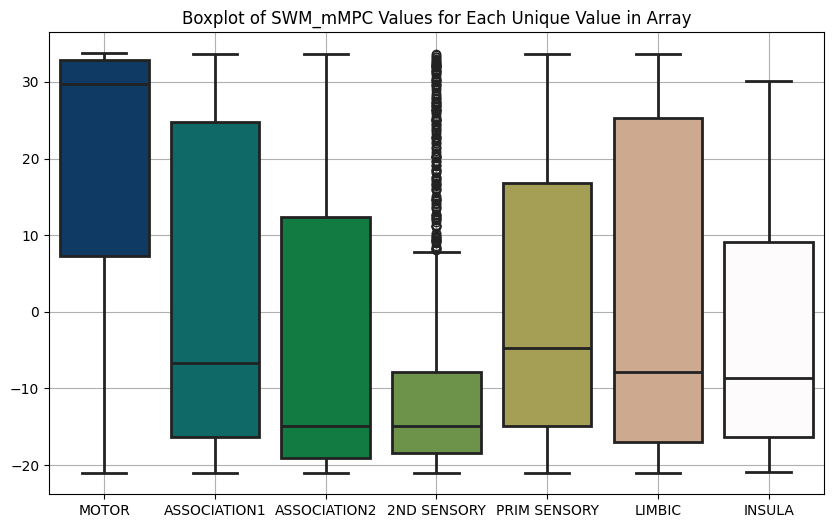

In [265]:
# Prepare data for seaborn
data_for_plot = []
for val in [1,2,3,4,5,6,7]:
    non_nan_values = SWM_mMPC[index[val]][~np.isnan(SWM_mMPC[index[val]])]
    data_for_plot.extend([(val, v) for v in non_nan_values])

# Convert to DataFrame
df = pd.DataFrame(data_for_plot, columns=['Unique Value', 'SWM_mMPC'])

# Define custom colors for each boxplot
custom_palette = ['#003b72ff', '#007874ff', '#008d41ff', '#6d9f3eff', '#b3aa47ff', '#d7a785ff', '#fefbfdff']

# Plot the boxplot using seaborn
plt.figure(figsize=(10, 6))

sns.boxplot(x='Unique Value', y='SWM_mMPC', data=df, palette=custom_palette, linewidth=2)

plt.xlabel('')
plt.ylabel('')
plt.title('Boxplot of SWM_mMPC Values for Each Unique Value in Array')
plt.grid(True)

# Change x-axis labels
new_labels = ['MOTOR', 'ASSOCIATION1', 'ASSOCIATION2', '2ND SENSORY', 'PRIM SENSORY', 'LIMBIC', 'INSULA']
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=new_labels)

plt.show()

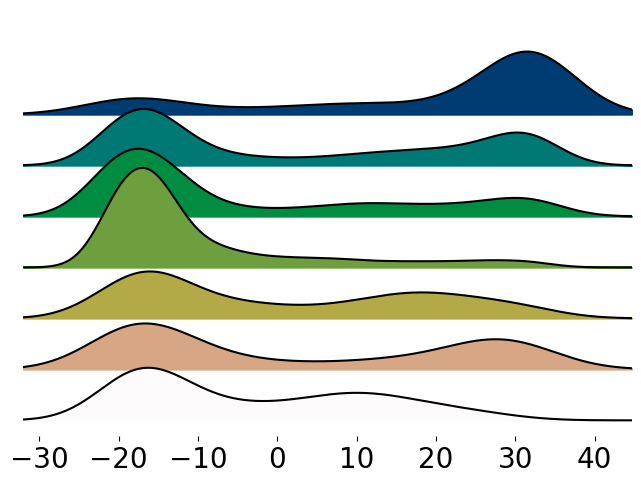

In [266]:
grouped_data = [df[df['Unique Value'] == val]['SWM_mMPC'].values for val in df['Unique Value'].unique()]

fig, ax = joypy.joyplot(grouped_data, color = custom_palette)

plt.xticks(fontsize=20)
plt.show()

In [190]:
unique_values = df['Unique Value'].unique()

# Iterate through each unique value to create and evaluate a regression model
for value in unique_values:
    # Filter the dataframe for the current unique value
    df_filtered = df[df['Unique Value'] == value]
    
    # Set features and target
    y = df_filtered['SWM_mMPC']
    
    # Add a constant term for the intercept
    X = sm.add_constant(df_filtered[['Unique Value']])
    
    # Initialize and train the regression model using statsmodels
    model = sm.OLS(y, X).fit()
    
    # Make predictions
    y_pred = model.predict(X)
    
    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Extract p-value for the independent variable
    p_value = model.pvalues['Unique Value']
    
    # Extract the regression coefficients
    coef = model.params['Unique Value']
    
    print(f'Unique Value: {value}')
    print(f'MSE: {mse}')
    print(f'R2: {r2}')
    print(f'p-value: {p_value}')
    print(f'Coefficients (Predictors): {coef}')

    #print(model.summary())
    print('-' * 50)

Unique Value: 1
MSE: 362.5151756456734
R2: 1.1102230246251565e-16
p-value: 3.301892640813448e-72
Coefficients (Predictors): 18.506666392871406
--------------------------------------------------
Unique Value: 2
MSE: 420.6712184395572
R2: 0.0
p-value: 4.88004185150984e-12
Coefficients (Predictors): 1.195809394343125
--------------------------------------------------
Unique Value: 3
MSE: 352.10153722761294
R2: 0.0
p-value: 8.294694929957417e-16
Coefficients (Predictors): -1.238281194213997
--------------------------------------------------
Unique Value: 4
MSE: 176.9261533985801
R2: 0.0
p-value: 1.7599883071235857e-149
Coefficients (Predictors): -2.500983342836179
--------------------------------------------------
Unique Value: 5
MSE: 310.4435960562383
R2: 0.0
p-value: 0.5280999043195136
Coefficients (Predictors): 0.09261118070333152
--------------------------------------------------
Unique Value: 6
MSE: 417.3943106740477
R2: 0.0
p-value: 0.007581605566152496
Coefficients (Predictors): 0.3

/tmp/ipykernel_2255056/2948964085.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Unique Value', y='GM_T1map', data=df, palette=custom_palette, linewidth=2)


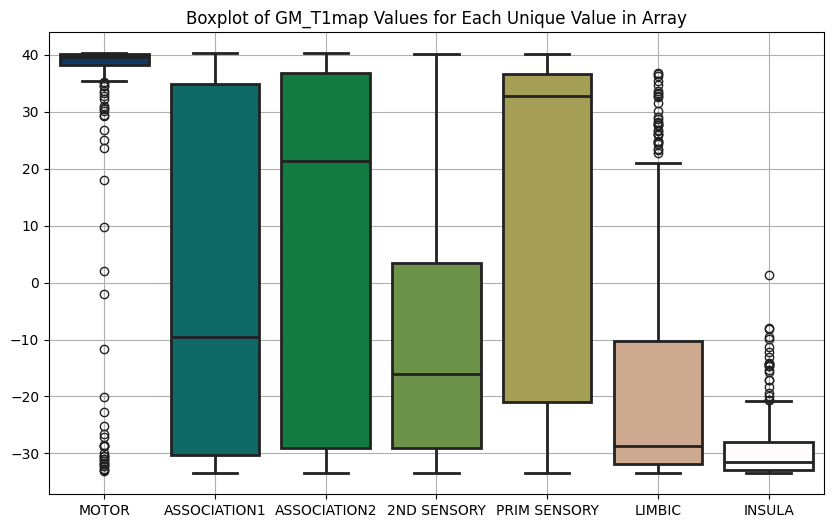

In [226]:
# Prepare data for seaborn
data_for_plot = []
for val in [1,2,3,4,5,6,7]:
    non_nan_values = GM_T1map[index[val]][~np.isnan(GM_T1map[index[val]])]
    data_for_plot.extend([(val, v) for v in non_nan_values])

# Convert to DataFrame
df = pd.DataFrame(data_for_plot, columns=['Unique Value', 'GM_T1map'])

# Define custom colors for each boxplot
custom_palette = ['#003b72ff', '#007874ff', '#008d41ff', '#6d9f3eff', '#b3aa47ff', '#d7a785ff', '#fefbfdff']

# Plot the boxplot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Unique Value', y='GM_T1map', data=df, palette=custom_palette, linewidth=2)
plt.xlabel('')
plt.ylabel('')
plt.title('Boxplot of GM_T1map Values for Each Unique Value in Array')
plt.grid(True)

# Change x-axis labels
new_labels = ['MOTOR', 'ASSOCIATION1', 'ASSOCIATION2', '2ND SENSORY', 'PRIM SENSORY', 'LIMBIC', 'INSULA']
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=new_labels)

plt.show()

In [192]:
unique_values = df['Unique Value'].unique()

# Iterate through each unique value to create and evaluate a regression model
for value in unique_values:
    # Filter the dataframe for the current unique value
    df_filtered = df[df['Unique Value'] == value]
    
    # Set features and target
    y = df_filtered['GM_T1map']
    
    # Add a constant term for the intercept
    X = sm.add_constant(df_filtered[['Unique Value']])
    
    # Initialize and train the regression model using statsmodels
    model = sm.OLS(y, X).fit()
    
    # Make predictions
    y_pred = model.predict(X)
    
    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Extract p-value for the independent variable
    p_value = model.pvalues['Unique Value']
    
    # Extract the regression coefficients
    coef = model.params['Unique Value']
    
    print(f'Unique Value: {value}')
    print(f'MSE: {mse}')
    print(f'R2: {r2}')
    print(f'p-value: {p_value}')
    print(f'Coefficients (Predictors): {coef}')

    #print(model.summary())
    print('-' * 50)

Unique Value: 1
MSE: 236.03085271649005
R2: 1.1102230246251565e-16
p-value: 1.1021025246383491e-195
Coefficients (Predictors): 35.23250921359914
--------------------------------------------------
Unique Value: 2
MSE: 892.9465392265091
R2: 0.0
p-value: 0.3189725926371063
Coefficients (Predictors): -0.2504711253117038
--------------------------------------------------
Unique Value: 3
MSE: 946.1330796569117
R2: -2.220446049250313e-16
p-value: 1.0932222780560371e-20
Coefficients (Predictors): 2.3596135488788326
--------------------------------------------------
Unique Value: 4
MSE: 496.7544023965855
R2: 3.3306690738754696e-16
p-value: 6.1548774514842006e-58
Coefficients (Predictors): -2.4002487683177813
--------------------------------------------------
Unique Value: 5
MSE: 848.0237123208182
R2: 0.0
p-value: 8.770086733406312e-27
Coefficients (Predictors): 2.7336951558696043
--------------------------------------------------
Unique Value: 6
MSE: 322.62408006492984
R2: 0.0
p-value: 3.848248

/tmp/ipykernel_2255056/330513822.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Unique Value', y='SWM_T1map', data=df, palette=custom_palette, linewidth=2)


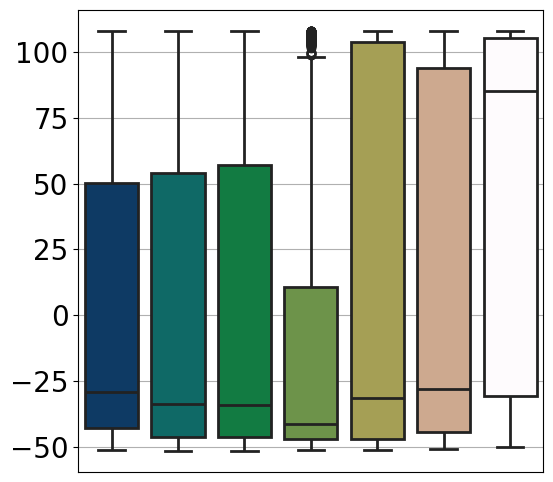

In [227]:
# Prepare data for seaborn
data_for_plot = []
for val in [1,2,3,4,5,6,7]:
    non_nan_values = SWM_T1map[index[val]][~np.isnan(SWM_T1map[index[val]])]
    data_for_plot.extend([(val, v) for v in non_nan_values])

# Convert to DataFrame
df = pd.DataFrame(data_for_plot, columns=['Unique Value', 'SWM_T1map'])

# Define custom colors for each boxplot
custom_palette = ['#003b72ff', '#007874ff', '#008d41ff', '#6d9f3eff', '#b3aa47ff', '#d7a785ff', '#fefbfdff']

# Plot the boxplot using seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(x='Unique Value', y='SWM_T1map', data=df, palette=custom_palette, linewidth=2)
plt.xlabel('')
plt.ylabel('')
#plt.title('Boxplot of SWM_T1map Values for Each Unique Value in Array')
plt.grid(True)

# Change x-axis labels
#new_labels = ['MOTOR', 'ASSOCIATION1', 'ASSOCIATION2', '2ND SENSORY', 'PRIM SENSORY', 'LIMBIC', 'INSULA']
plt.xticks(ticks=[])
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed

plt.show()

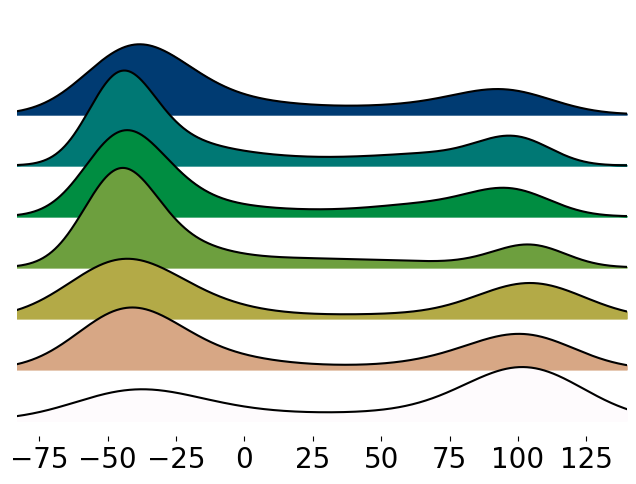

In [228]:
grouped_data = [df[df['Unique Value'] == val]['SWM_T1map'].values for val in df['Unique Value'].unique()]

fig, ax = joypy.joyplot(grouped_data, color = custom_palette)

plt.xticks(fontsize=20)
plt.show()

In [194]:
unique_values = df['Unique Value'].unique()

# Iterate through each unique value to create and evaluate a regression model
for value in unique_values:
    # Filter the dataframe for the current unique value
    df_filtered = df[df['Unique Value'] == value]
    
    # Set features and target
    y = df_filtered['SWM_T1map']
    
    # Add a constant term for the intercept
    X = sm.add_constant(df_filtered[['Unique Value']])
    
    # Initialize and train the regression model using statsmodels
    model = sm.OLS(y, X).fit()
    
    # Make predictions
    y_pred = model.predict(X)
    
    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Extract p-value for the independent variable
    p_value = model.pvalues['Unique Value']
    
    # Extract the regression coefficients
    coef = model.params['Unique Value']
    
    print(f'Unique Value: {value}')
    print(f'MSE: {mse}')
    print(f'R2: {r2}')
    print(f'p-value: {p_value}')
    print(f'Coefficients (Predictors): {coef}')

    #print(model.summary())
    print('-' * 50)

Unique Value: 1
MSE: 3017.880126956421
R2: 0.0
p-value: 0.7821343184081678
Coefficients (Predictors): 0.6894921406967556
--------------------------------------------------
Unique Value: 2
MSE: 3238.9038034587775
R2: 0.0
p-value: 0.4052347621744148
Coefficients (Predictors): -0.39839209255169755
--------------------------------------------------
Unique Value: 3
MSE: 3283.899362636072
R2: 0.0
p-value: 0.5289684278483672
Coefficients (Predictors): -0.2929454587771072
--------------------------------------------------
Unique Value: 4
MSE: 2968.4954958754483
R2: 0.0
p-value: 1.8029584373046365e-12
Coefficients (Predictors): -2.489202222510077
--------------------------------------------------
Unique Value: 5
MSE: 4621.15317881913
R2: 0.0
p-value: 5.034825228513332e-05
Coefficients (Predictors): 2.3120211160404915
--------------------------------------------------
Unique Value: 6
MSE: 4218.810134879942
R2: 0.0
p-value: 8.93747305906872e-07
Coefficients (Predictors): 2.051189839755182
-------

/tmp/ipykernel_2255056/755194714.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Unique Value', y='SWM_MTSAT_new', data=df, palette=custom_palette, linewidth=2)


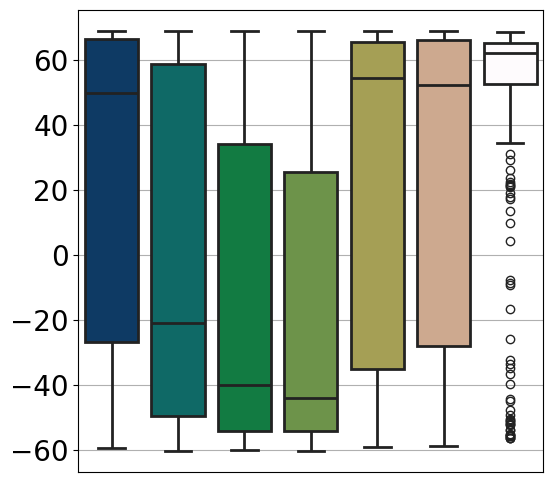

In [229]:
# Prepare data for seaborn
data_for_plot = []
for val in [1,2,3,4,5,6,7]:
    non_nan_values = SWM_MTSAT_new[index[val]][~np.isnan(SWM_MTSAT_new[index[val]])]
    data_for_plot.extend([(val, v) for v in non_nan_values])

# Convert to DataFrame
df = pd.DataFrame(data_for_plot, columns=['Unique Value', 'SWM_MTSAT_new'])

# Define custom colors for each boxplot
custom_palette = ['#003b72ff', '#007874ff', '#008d41ff', '#6d9f3eff', '#b3aa47ff', '#d7a785ff', '#fefbfdff']

# Plot the boxplot using seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(x='Unique Value', y='SWM_MTSAT_new', data=df, palette=custom_palette, linewidth=2)
plt.xlabel('')
plt.ylabel('')
#plt.title('Boxplot of SWM_MTSAT_new Values for Each Unique Value in Array')
plt.grid(True)

# Change x-axis labels
#new_labels = ['MOTOR', 'ASSOCIATION1', 'ASSOCIATION2', '2ND SENSORY', 'PRIM SENSORY', 'LIMBIC', 'INSULA']
plt.xticks(ticks=[])
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed

plt.show()

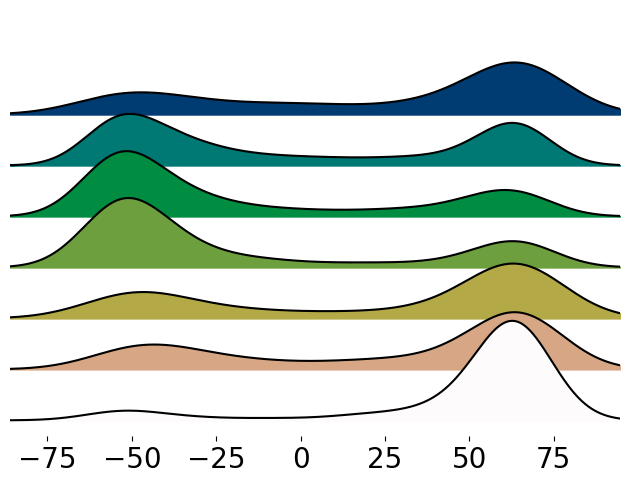

In [230]:
grouped_data = [df[df['Unique Value'] == val]['SWM_MTSAT_new'].values for val in df['Unique Value'].unique()]

fig, ax = joypy.joyplot(grouped_data, color = custom_palette)

plt.xticks(fontsize=20)
plt.show()

In [196]:
unique_values = df['Unique Value'].unique()

# Iterate through each unique value to create and evaluate a regression model
for value in unique_values:
    # Filter the dataframe for the current unique value
    df_filtered = df[df['Unique Value'] == value]
    
    # Set features and target
    y = df_filtered['SWM_MTSAT_new']
    
    # Add a constant term for the intercept
    X = sm.add_constant(df_filtered[['Unique Value']])
    
    # Initialize and train the regression model using statsmodels
    model = sm.OLS(y, X).fit()
    
    # Make predictions
    y_pred = model.predict(X)
    
    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Extract p-value for the independent variable
    p_value = model.pvalues['Unique Value']
    
    # Extract the regression coefficients
    coef = model.params['Unique Value']
    
    print(f'Unique Value: {value}')
    print(f'MSE: {mse}')
    print(f'R2: {r2}')
    print(f'p-value: {p_value}')
    print(f'Coefficients (Predictors): {coef}')

    #print(model.summary())
    print('-' * 50)

Unique Value: 1
MSE: 2280.3119782782924
R2: 0.0
p-value: 3.16654092456665e-25
Coefficients (Predictors): 23.794685370256463
--------------------------------------------------
Unique Value: 2
MSE: 2504.764388689745
R2: 0.0
p-value: 0.17197346433357838
Coefficients (Predictors): -0.574992941570074
--------------------------------------------------
Unique Value: 3
MSE: 2204.3165723262346
R2: 2.220446049250313e-16
p-value: 1.5917667097556837e-38
Coefficients (Predictors): -5.074154993772618
--------------------------------------------------
Unique Value: 4
MSE: 2234.485557817396
R2: -2.220446049250313e-16
p-value: 8.833111824830765e-45
Coefficients (Predictors): -4.409215359381608
--------------------------------------------------
Unique Value: 5
MSE: 2407.9955568613627
R2: 0.0
p-value: 8.376835484538334e-27
Coefficients (Predictors): 4.60854315021278
--------------------------------------------------
Unique Value: 6
MSE: 2204.456299866396
R2: 1.1102230246251565e-16
p-value: 3.030455554423

/tmp/ipykernel_2255056/3455970697.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Unique Value', y='SWM_FA', data=df, palette=custom_palette, linewidth=2)


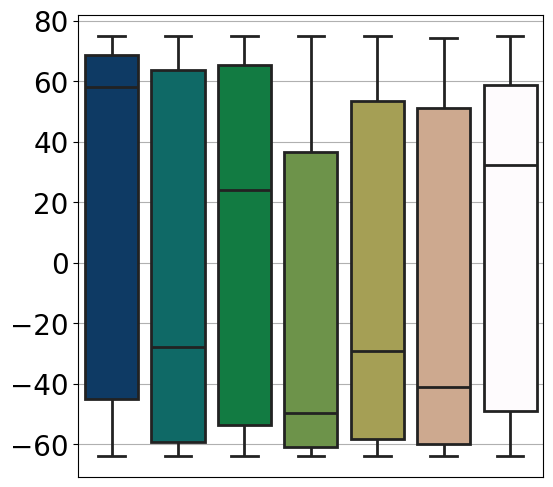

In [231]:
# Prepare data for seaborn
data_for_plot = []
for val in [1,2,3,4,5,6,7]:
    non_nan_values = SWM_FA[index[val]][~np.isnan(SWM_FA[index[val]])]
    data_for_plot.extend([(val, v) for v in non_nan_values])

# Convert to DataFrame
df = pd.DataFrame(data_for_plot, columns=['Unique Value', 'SWM_FA'])

# Define custom colors for each boxplot
custom_palette = ['#003b72ff', '#007874ff', '#008d41ff', '#6d9f3eff', '#b3aa47ff', '#d7a785ff', '#fefbfdff']

# Plot the boxplot using seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(x='Unique Value', y='SWM_FA', data=df, palette=custom_palette, linewidth=2)

plt.xlabel('')
plt.ylabel('')
#plt.title('Boxplot of SWM_FA Values for Each Unique Value in Array')
plt.grid(True)

# Change x-axis labels
#new_labels = ['MOTOR', 'ASSOCIATION1', 'ASSOCIATION2', '2ND SENSORY', 'PRIM SENSORY', 'LIMBIC', 'INSULA']
plt.xticks(ticks=[])
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed

plt.show()

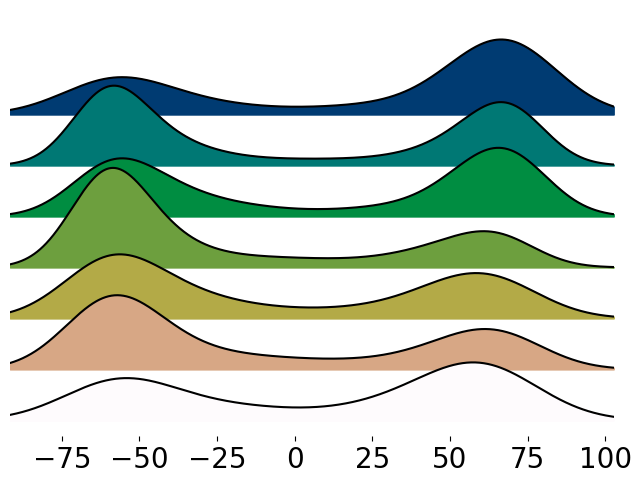

In [232]:
grouped_data = [df[df['Unique Value'] == val]['SWM_FA'].values for val in df['Unique Value'].unique()]

fig, ax = joypy.joyplot(grouped_data, color = custom_palette)

plt.xticks(fontsize=20)
plt.show()

In [198]:
unique_values = df['Unique Value'].unique()

# Iterate through each unique value to create and evaluate a regression model
for value in unique_values:
    # Filter the dataframe for the current unique value
    df_filtered = df[df['Unique Value'] == value]
    
    # Set features and target
    y = df_filtered['SWM_FA']
    
    # Add a constant term for the intercept
    X = sm.add_constant(df_filtered[['Unique Value']])
    
    # Initialize and train the regression model using statsmodels
    model = sm.OLS(y, X).fit()
    
    # Make predictions
    y_pred = model.predict(X)
    
    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Extract p-value for the independent variable
    p_value = model.pvalues['Unique Value']
    
    # Extract the regression coefficients
    coef = model.params['Unique Value']
    
    print(f'Unique Value: {value}')
    print(f'MSE: {mse}')
    print(f'R2: {r2}')
    print(f'p-value: {p_value}')
    print(f'Coefficients (Predictors): {coef}')

    #print(model.summary())
    print('-' * 50)

Unique Value: 1
MSE: 3047.473449443945
R2: 0.0
p-value: 1.6768822350567715e-18
Coefficients (Predictors): 22.89185157332557
--------------------------------------------------
Unique Value: 2
MSE: 3309.840635413835
R2: 0.0
p-value: 0.15003379525987642
Coefficients (Predictors): -0.6965597090834349
--------------------------------------------------
Unique Value: 3
MSE: 3176.3221325196278
R2: 0.0
p-value: 1.012742253223665e-09
Coefficients (Predictors): 2.8102131237079906
--------------------------------------------------
Unique Value: 4
MSE: 2576.5156758045505
R2: 0.0
p-value: 8.241682399510697e-50
Coefficients (Predictors): -5.023416853170103
--------------------------------------------------
Unique Value: 5
MSE: 2823.4636088044344
R2: 0.0
p-value: 0.005126387847351041
Coefficients (Predictors): -1.2430782960381836
--------------------------------------------------
Unique Value: 6
MSE: 2824.5898919708607
R2: 0.0
p-value: 9.55516043512698e-09
Coefficients (Predictors): -1.966423961752400

/tmp/ipykernel_2255056/2785898321.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Unique Value', y='SWM_ODI', data=df, palette=custom_palette, linewidth=2)


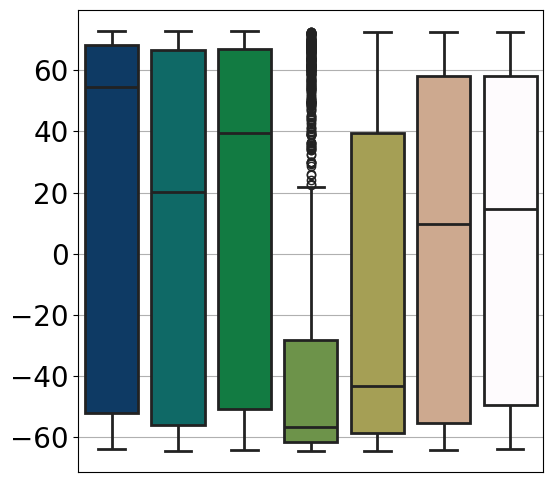

In [263]:
# Prepare data for seaborn
data_for_plot = []
for val in [1,2,3,4,5,6,7]:
    non_nan_values = SWM_ODI[index[val]][~np.isnan(SWM_ODI[index[val]])]
    data_for_plot.extend([(val, v) for v in non_nan_values])

# Convert to DataFrame
df = pd.DataFrame(data_for_plot, columns=['Unique Value', 'SWM_ODI'])

# Define custom colors for each boxplot
custom_palette = ['#003b72ff', '#007874ff', '#008d41ff', '#6d9f3eff', '#b3aa47ff', '#d7a785ff', '#fefbfdff']

# Plot the boxplot using seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(x='Unique Value', y='SWM_ODI', data=df, palette=custom_palette, linewidth=2)
plt.xlabel('')
plt.ylabel('')
#plt.title('Boxplot of SWM_ODI Values for Each Unique Value in Array')
plt.grid(True)

# Change x-axis labels
#new_labels = ['MOTOR', 'ASSOCIATION1', 'ASSOCIATION2', '2ND SENSORY', 'PRIM SENSORY', 'LIMBIC', 'INSULA']
plt.xticks(ticks=[])
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed

plt.show()

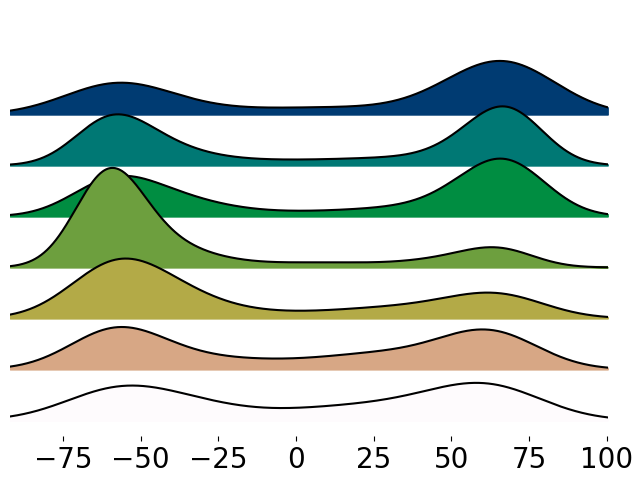

In [264]:
grouped_data = [df[df['Unique Value'] == val]['SWM_ODI'].values for val in df['Unique Value'].unique()]

fig, ax = joypy.joyplot(grouped_data, color = custom_palette)

plt.xticks(fontsize=20)
plt.show()

In [200]:
unique_values = df['Unique Value'].unique()

# Iterate through each unique value to create and evaluate a regression model
for value in unique_values:
    # Filter the dataframe for the current unique value
    df_filtered = df[df['Unique Value'] == value]
    
    # Set features and target
    y = df_filtered['SWM_ODI']
    
    # Add a constant term for the intercept
    X = sm.add_constant(df_filtered[['Unique Value']])
    
    # Initialize and train the regression model using statsmodels
    model = sm.OLS(y, X).fit()
    
    # Make predictions
    y_pred = model.predict(X)
    
    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Extract p-value for the independent variable
    p_value = model.pvalues['Unique Value']
    
    # Extract the regression coefficients
    coef = model.params['Unique Value']
    
    print(f'Unique Value: {value}')
    print(f'MSE: {mse}')
    print(f'R2: {r2}')
    print(f'p-value: {p_value}')
    print(f'Coefficients (Predictors): {coef}')

    #print(model.summary())
    print('-' * 50)

Unique Value: 1
MSE: 3962.9334052449926
R2: 2.220446049250313e-16
p-value: 5.392321985459569e-08
Coefficients (Predictors): -15.77564966653659
--------------------------------------------------
Unique Value: 2
MSE: 4101.6430942324505
R2: 0.0
p-value: 0.0023293087507051183
Coefficients (Predictors): -1.641008697295087
--------------------------------------------------
Unique Value: 3
MSE: 3934.4191887280535
R2: 0.0
p-value: 5.767488171119263e-10
Coefficients (Predictors): -3.1738779044872762
--------------------------------------------------
Unique Value: 4
MSE: 2570.3203406075145
R2: -2.220446049250313e-16
p-value: 1.2076548848995714e-164
Coefficients (Predictors): 10.135893575511778
--------------------------------------------------
Unique Value: 5
MSE: 3250.3961087887733
R2: -2.220446049250313e-16
p-value: 5.3525178218106305e-19
Coefficients (Predictors): 4.378452847674439
--------------------------------------------------
Unique Value: 6
MSE: 3488.1036270612444
R2: 0.0
p-value: 0.35